In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import shapiro
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
# 1) CARREGAR DADOS E LIMPAR " --- "
df = pd.read_csv("data/chuvas.csv")

# Remove espaços dos nomes das colunas
df.columns = df.columns.str.strip()

# Trocar "---" por NaN
df = df.replace("---", np.nan)

# Converter colunas numéricas
for col in df.columns:
    if col != "Ano":
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Nulos antes do preenchimento:")
print(df.isna().sum())


Nulos antes do preenchimento:
Ano           0
Janeiro      80
Fevereiro    79
Março        79
Abril        78
Maio         80
Junho        83
Julho        80
Agosto       78
Setembro     80
Outubro      84
Novembro     78
Dezembro     81
dtype: int64


In [6]:
# 2) TRANSFORMAR PARA FORMATO LONGO
df_long = df.melt(id_vars="Ano", var_name="Mes", value_name="Chuva")

# Converter meses para número
mapa_meses = {
    "Janeiro": 1, "Fevereiro": 2, "Março": 3, "Abril": 4, "Maio": 5, "Junho": 6,
    "Julho": 7, "Agosto": 8, "Setembro": 9, "Outubro": 10, "Novembro": 11, "Dezembro": 12
}
df_long["Mes_num"] = df_long["Mes"].map(mapa_meses)

# Criar coluna de data
df_long["Data"] = pd.to_datetime(df_long["Ano"].astype(str) + "-" + df_long["Mes_num"].astype(str) + "-01")


In [7]:
# 3) PREENCHER NULOS PELA MÉDIA CLIMATOLÓGICA DO MÊS
media_mes = df_long.groupby("Mes_num")["Chuva"].transform("mean")
df_long["Chuva"] = df_long["Chuva"].fillna(media_mes)

print("Nulos depois do preenchimento:")
print(df_long["Chuva"].isna().sum())

Nulos depois do preenchimento:
0


In [8]:
# 4) CRIAR SÉRIE TEMPORAL
series = df_long.set_index("Data")["Chuva"].sort_index()

In [9]:
print(series.head())

Data
1936-01-01    273.625000
1936-02-01    206.444444
1936-03-01    224.555556
1936-04-01     23.000000
1936-05-01     57.000000
Name: Chuva, dtype: float64


count    1056.000000
mean      131.575893
std        75.068985
min         3.000000
25%        68.875000
50%       109.500000
75%       187.285714
max       473.000000
Name: Chuva, dtype: float64


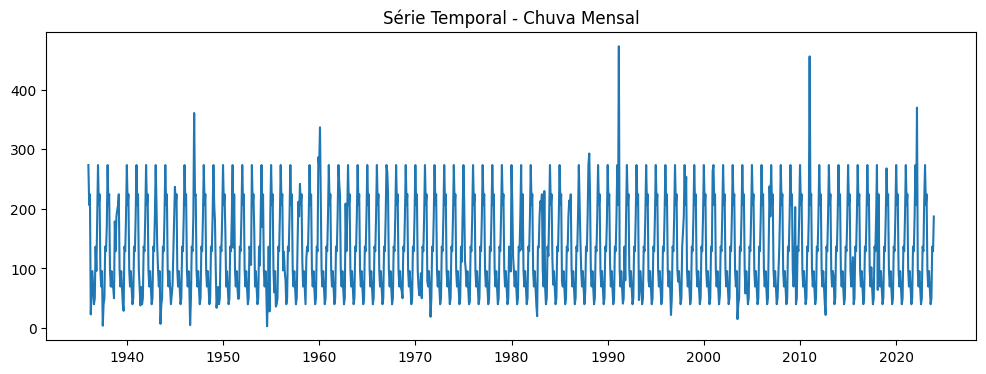

In [10]:
# 5) ANÁLISE BÁSICA
print(series.describe())
plt.figure(figsize=(12,4))
plt.plot(series)
plt.title("Série Temporal - Chuva Mensal")
plt.show()

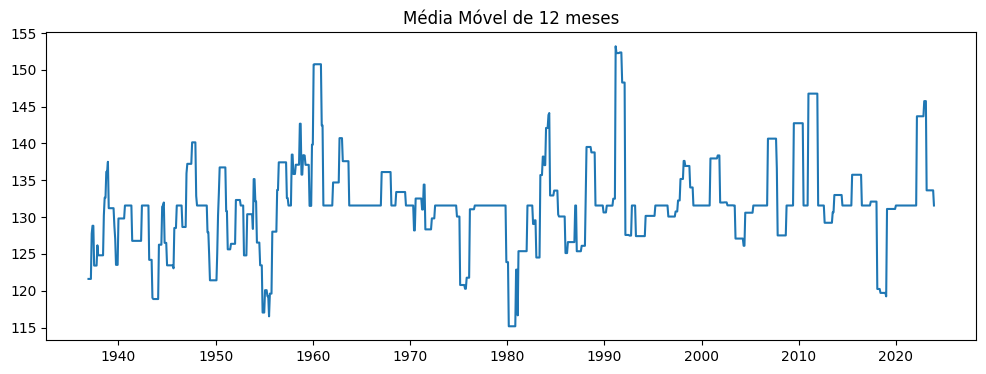

In [11]:
# 6) MÉDIA MÓVEL, ACF E PACF
plt.figure(figsize=(12,4))
plt.plot(series.rolling(12).mean())
plt.title("Média Móvel de 12 meses")
plt.show()

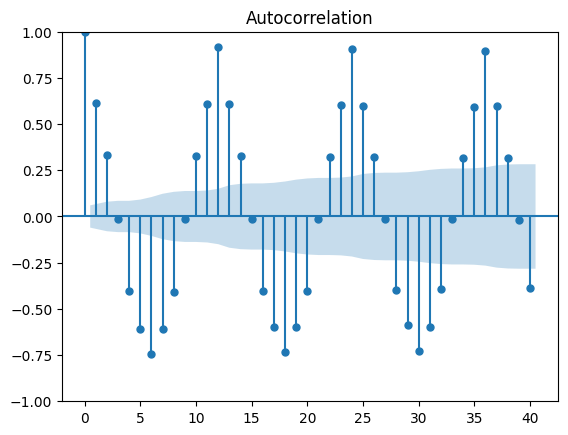

In [12]:
plot_acf(series, lags=40)
plt.show()

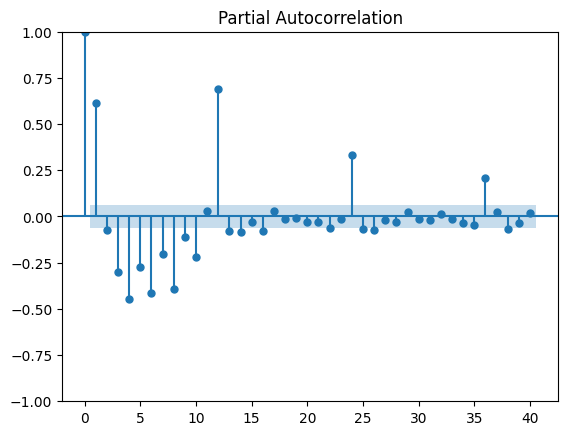

In [13]:
plot_pacf(series, lags=40)
plt.show()

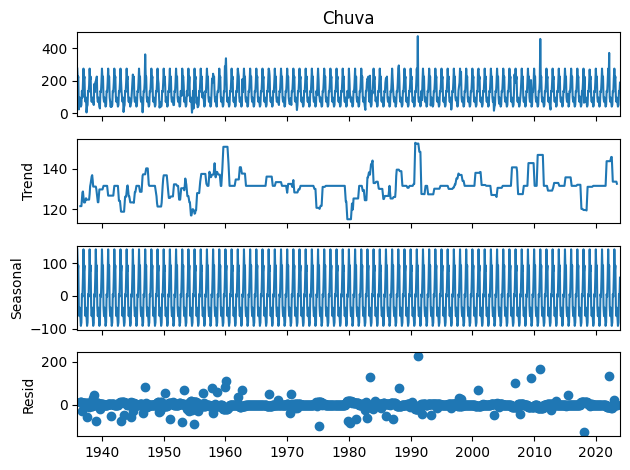

In [14]:
# 7) DECOMPOSIÇÃO
decomp = seasonal_decompose(series, model="additive", period=12)
decomp.plot()
plt.show()

In [15]:
# 8) TESTE DE ESTACIONARIEDADE E NORMALIDADE

adf = adfuller(series)
print("ADF:", adf[0])
print("p-value:", adf[1])

# Normalidade
stat, p = shapiro(series)
print("Shapiro-Wilk p-value:", p)

# Se não estacionária, diferenciar
if adf[1] > 0.05:
    series_diff = series.diff().dropna()
else:
    series_diff = series

ADF: -7.474065722925973
p-value: 4.9669457007374746e-11
Shapiro-Wilk p-value: 1.5983565174337344e-23


In [16]:
# Treino até os últimos 12 meses
train = series[:-12]
test = series[-12:]

# SARIMA AUTOMÁTICO
model = auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=4.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11983.428, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10972.167, Time=1.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=13447.477, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=11610.877, Time=0.31 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=10622.524, Time=2.55 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=10583.314, Time=6.31 sec
 ARIMA(0,0,1)(2,0,2)[12] intercept   : AIC=inf, Time=7.36 sec
 ARIMA(0,0,1)(2,0,1)[12] intercept   : AIC=12119.055, Time=3.54 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=10689.107, Time=5.29 sec
 ARIMA(1,0,1)(1,0,2)[12] intercept   : AIC=9944.014, Time=8.65 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=10575.298, Time=4.04 sec
 ARIMA(1,0,1)(1,0,1)[12] inter

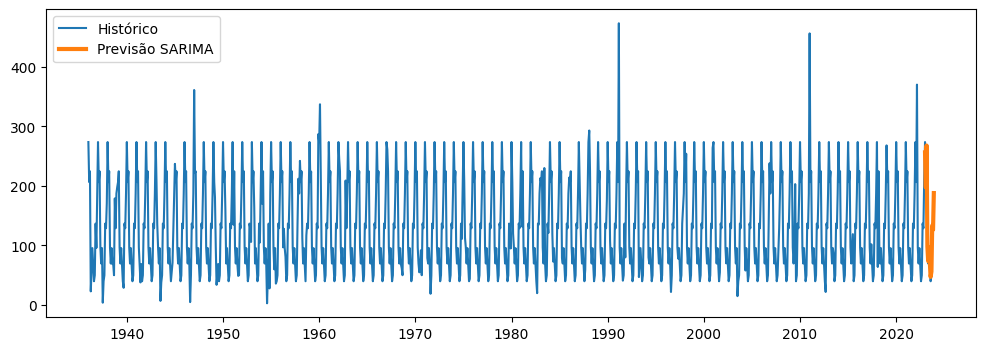

In [18]:
# PREVISÃO
forecast = model.predict(n_periods=12)
forecast = pd.Series(forecast, index=test.index)

plt.figure(figsize=(12,4))
plt.plot(series, label="Histórico")
plt.plot(forecast, label="Previsão SARIMA", linewidth=3)
plt.legend()
plt.show()

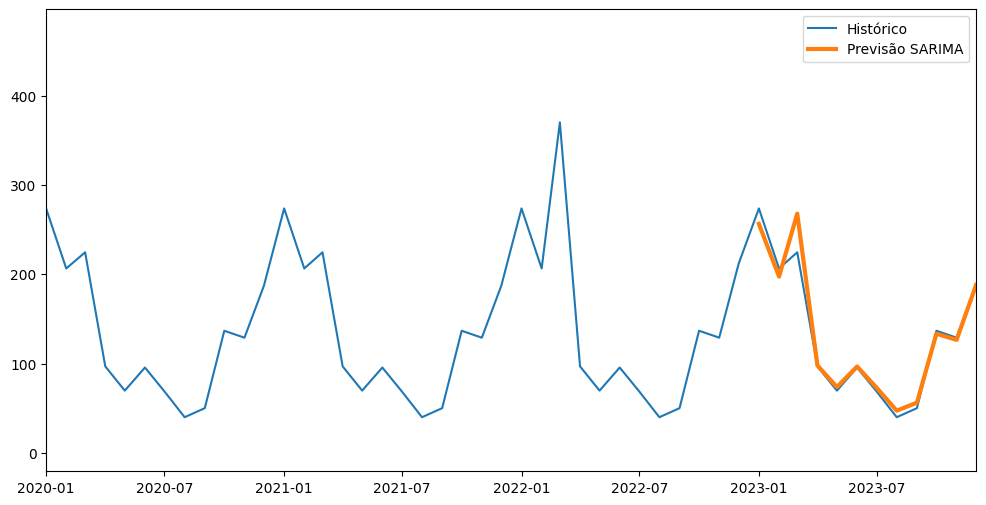

In [23]:
plt.figure(figsize=(12,6))
plt.plot(series, label="Histórico")
plt.plot(forecast, label="Previsão SARIMA", linewidth=3)

start_zoom = series.index[-48]

plt.xlim(start_zoom, forecast.index[-1])
plt.legend()
plt.show()

Dados de teste para avaliar a previsão

In [24]:
# 1) TREINO E TESTE
train = series[:-12]
test = series[-12:]

In [25]:
# 2) AJUSTAR MODELO SARIMA AUTOMÁTICO

model = auto_arima(
    train,
    seasonal=True,
    m=12,
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

In [26]:
# 3) PREVISÃO PARA O PERÍODO DE TESTE

forecast = model.predict(n_periods=12)
forecast = pd.Series(forecast, index=test.index)

In [30]:
# 4) MÉTRICAS DE AVALIAÇÃO

rmse = np.sqrt(mean_squared_error(test, forecast))
mae = mean_absolute_error(test, forecast)
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("📊 Avaliação do Modelo SARIMA:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

📊 Avaliação do Modelo SARIMA:
RMSE: 14.13
MAE:  8.33
MAPE: 6.61%


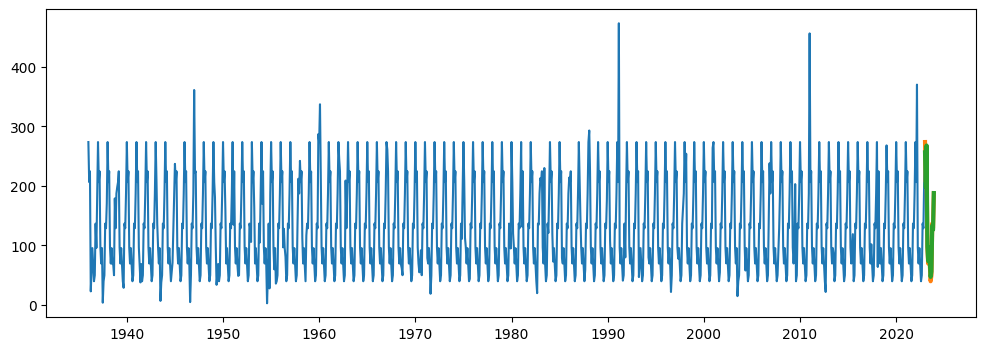

In [31]:
# 5) GRÁFICO — PREVISÃO VS REAL (com zoom no final)

plt.figure(figsize=(12,4))
plt.plot(series, label="Histórico")
plt.plot(test, label="Teste (Real)", linewidth=3)
plt.plot(forecast, label="Previsão SARIMA", linewidth=3)

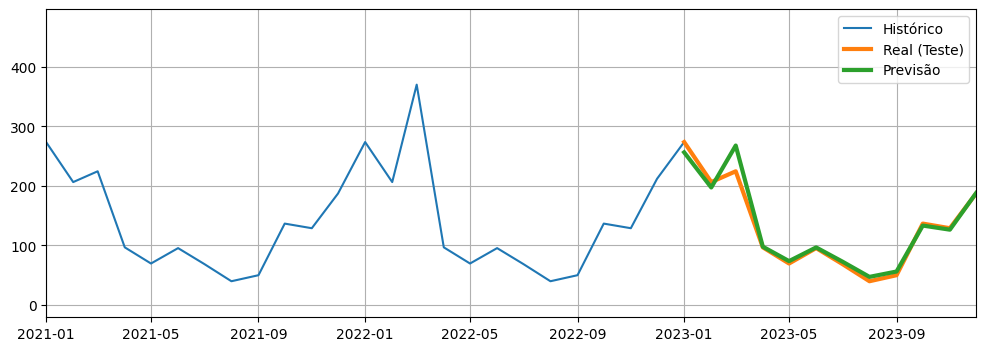

In [34]:
inicio_zoom = test.index[0] - pd.DateOffset(months=24)
fim_zoom = test.index[-1]

plt.figure(figsize=(12,4))
plt.plot(series, label="Histórico")
plt.plot(test, label="Real (Teste)", linewidth=3)
plt.plot(forecast, label="Previsão", linewidth=3)

plt.xlim(inicio_zoom, fim_zoom)
plt.legend()
plt.grid(True)
plt.show()